### Query a new dkd2 sample on the reference dkd1 object
Figure 8 and related supplemental figures are generated

Author: Dian Li, Pierre Isnard, Haojia Wu

Contact: dianli@wustl.edu

Last updated: January 31, 2024

In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))

In [2]:
plots_path_main = "../../plots/version_1/main_figures"
plots_path_supp = "../../plots/version_1/supp_figures"
processed_data_path = "../../processed_data/version_1/FindMarkers"

dir.create(plots_path_main, showWarnings = F, recursive = T)
dir.create(plots_path_supp, showWarnings = F, recursive = T)
dir.create(processed_data_path, showWarnings = F, recursive = T)

### Step 1. Load dkd1 Seurat object generated from Figure 1

In [3]:
load("../../processed_data/version_1/dkd1_umap.RData")

In [4]:
load("../../meta/meta_info2.RData")

In [5]:
dkd1

An object of class Seurat 
36131 features across 2802 samples within 2 assays 
Active assay: SCT (18046 features, 3000 variable features)
 1 other assay present: Spatial
 2 dimensional reductions calculated: pca, umap
 1 image present: slice1

#### Step 1.2. Add glomeruli meta data

In [6]:
glom_meta<-read.csv("../../meta/spots_selection - dkd_glom_v2_1.csv")

In [7]:
df_meta_glom = glom_meta
colnames(df_meta_glom) = c("barcode", "glom_id", "glom_class")
rownames(df_meta_glom) = df_meta_glom$barcode

df_meta = data.frame("Barcode" = dkd1$Barcode)
df_meta$glom_id = "none"
df_meta$glom_class = "none"
df_meta$Morph.based.glom = as.vector(dkd1$Morph.based)

df_meta[df_meta_glom$barcode, "glom_id"] = df_meta_glom$glom_id
df_meta[df_meta_glom$barcode, "glom_class"] = df_meta_glom$glom_class
df_meta[df_meta_glom$barcode, "Morph.based.glom"] = df_meta_glom$glom_class

In [8]:
df_meta$Morph.based.glom <- factor(df_meta$Morph.based.glom, levels = names(color_palette2))

In [9]:
meta_tmp = dkd1@meta.data
meta_tmp$Barcode = rownames(meta_tmp)
meta_tmp = left_join(meta_tmp, df_meta, by = "Barcode")
rownames(meta_tmp) = meta_tmp$Barcode

dkd1@meta.data = meta_tmp
head(dkd1@meta.data)

,orig.ident,nCount_Spatial,nFeature_Spatial,Barcode,Morph.based,percent.mt,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,glom_id,glom_class,Morph.based.glom
,<fct>,<dbl>,<int>,<chr>,<fct>,<dbl>,<dbl>,<int>,<fct>,<fct>,<chr>,<chr>,<fct>
AACACTTGGCAAGGAA-1,SeuratProject,37726,9197,AACACTTGGCAAGGAA-1,Tumor,2.534061,16669,6999,7,7,none,none,Tumor
AACAGGATTCATAGTT-1,SeuratProject,15426,6541,AACAGGATTCATAGTT-1,Glomeruli,1.277065,15430,6541,3,3,G40,DKDG,DKDG
AACAGGTTATTGCACC-1,SeuratProject,19244,7267,AACAGGTTATTGCACC-1,PT,3.138641,16972,7266,0,0,none,none,PT
AACAGGTTCACCGAAG-1,SeuratProject,24380,8180,AACAGGTTCACCGAAG-1,LH-CD,2.038556,16653,7770,11,11,none,none,LH-CD
AACAGTCAGGCTCCGC-1,SeuratProject,22432,8043,AACAGTCAGGCTCCGC-1,Other,2.166548,16784,7878,11,11,none,none,Other
AACATCTTAAGGCTCA-1,SeuratProject,18935,7598,AACATCTTAAGGCTCA-1,Other,4.182730,17050,7597,1,1,none,none,Other


### Step 2. Load query Seurat object

#### Step 2.1. Update tissue_positions_list.csv file

In [10]:
df = read.csv("/home/data/dianli/projects/test/pierre/data/FFPE_D2/outs/spatial/tissue_positions.csv")

In [11]:
df$pxl_row_in_fullres = floor(df$pxl_row_in_fullres)
df$pxl_col_in_fullres = floor(df$pxl_col_in_fullres)
write.csv(df, file = "/home/data/dianli/projects/test/pierre/data/FFPE_D2/outs/spatial/tissue_positions_list.csv",row.names = FALSE)

#### Step 2.2. Load and create dkd2 Seurat object

In [12]:
dkd2 = Load10X_Spatial("/home/data/dianli/projects/test/pierre/data/FFPE_D2/outs/")

In [13]:
dkd2

An object of class Seurat 
18085 features across 3041 samples within 1 assay 
Active assay: Spatial (18085 features, 0 variable features)
 1 image present: slice1

### Step 3. Transfer using full dkd1 object with Unimodal UMAP Projection

#### Step 3.1. SCTransform dkd2

In [14]:
dkd2 <- SCTransform(dkd2, assay = "Spatial", verbose = FALSE)

#### Step 3.2. Find anchors between dkd1 and dkd2

In [15]:
anchors <- FindTransferAnchors(reference = dkd1, query = dkd2, dims = 1:30,
                               normalization.method = 'SCT',
                               reference.reduction = "pca")

Normalizing query using reference SCT model

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 2087 anchors



#### Step 3.3. Rerun UMAP for dkd1 as the default value for return.model is FALSE

In [16]:
dkd1 <- RunUMAP(dkd1, reduction = "pca", dims = 1:20, min.dist = 0.1, return.model = TRUE, verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


#### Step 3.4. Unimodal UMAP Projection

In [17]:
dkd2 <- MapQuery(anchorset = anchors, reference = dkd1, query = dkd2,
    refdata = list(celltype = "Morph.based.glom"), reference.reduction = "pca", reduction.model = "umap")

Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours.”
Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

19:35:24 Read 3041 rows

19:35:24 Processing block 1 of 1

19:35:24 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

19:35:24 Initializing by weighted average of neighbor coordinates using 1 thread

19:35:24 Commencing optimization for 167 epochs, with 91230 positive edges

19:35:25 Finished



#### Step 3.5. Reorder predicted.celltype

In [18]:
dkd2$predicted.celltype <- factor(dkd2$predicted.celltype, levels = names(color_palette2))

#### Step 3.6. Visualization

In [19]:
empty_theme = theme(
        axis.line=element_blank(),
        axis.title=element_blank(),
        axis.text=element_blank(),
        axis.ticks=element_blank())
custom_theme <- theme(text = element_text(family = "Helvetica"))

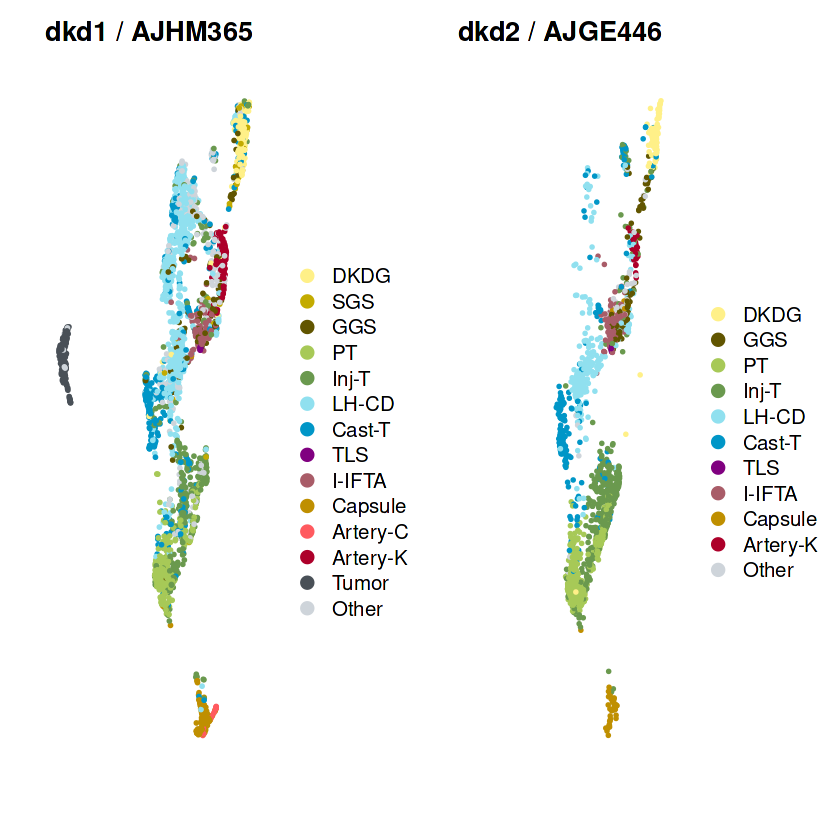

In [20]:
p1 <- DimPlot(dkd1, reduction = "umap", group.by = "Morph.based.glom", label = FALSE, label.size = 3,
    repel = TRUE, cols = color_palette2) + ggtitle("dkd1 / AJHM365") + xlim(-15,8) + ylim(-9,6) + empty_theme
p2 <- DimPlot(dkd2, reduction = "ref.umap", group.by = "predicted.celltype", label = FALSE,
    label.size = 3, repel = TRUE, cols = color_palette2) + ggtitle("dkd2 / AJGE446") + xlim(-15,8) + ylim(-9,6) + empty_theme
p = p1 | p2
p

ggsave(p, filename = file.path(plots_path_main, "DimPlot_dkd2_query_dkd1.png"), width = 11, height = 5, units = "in", dpi = 300)
ggsave(p, filename = file.path(plots_path_main, "DimPlot_dkd2_query_dkd1.pdf"), width = 11, height = 5, units = "in", dpi = 300)


In [21]:
table(dkd2$predicted.celltype)


    DKDG      SGS      GGS       PT    Inj-T    LH-CD   Cast-T      TLS 
     144        0      101     1503      515      230      239       26 
  I-IFTA  Capsule Artery-C Artery-K    Tumor    Other 
     147       51        0       42        0       43 

#### Step 3.7. Spatial Dimplot

In [22]:
dkd2@images[["slice1"]]@coordinates[["tissue"]] <- as.numeric(dkd2@images[["slice1"]]@coordinates[["tissue"]])
dkd2@images[["slice1"]]@coordinates[["row"]] <- as.numeric(dkd2@images[["slice1"]]@coordinates[["row"]])
dkd2@images[["slice1"]]@coordinates[["col"]] <- as.numeric(dkd2@images[["slice1"]]@coordinates[["col"]])
dkd2@images[["slice1"]]@coordinates[["imagerow"]] <- as.numeric(dkd2@images[["slice1"]]@coordinates[["imagerow"]])
dkd2@images[["slice1"]]@coordinates[["imagecol"]] <- as.numeric(dkd2@images[["slice1"]]@coordinates[["imagecol"]])

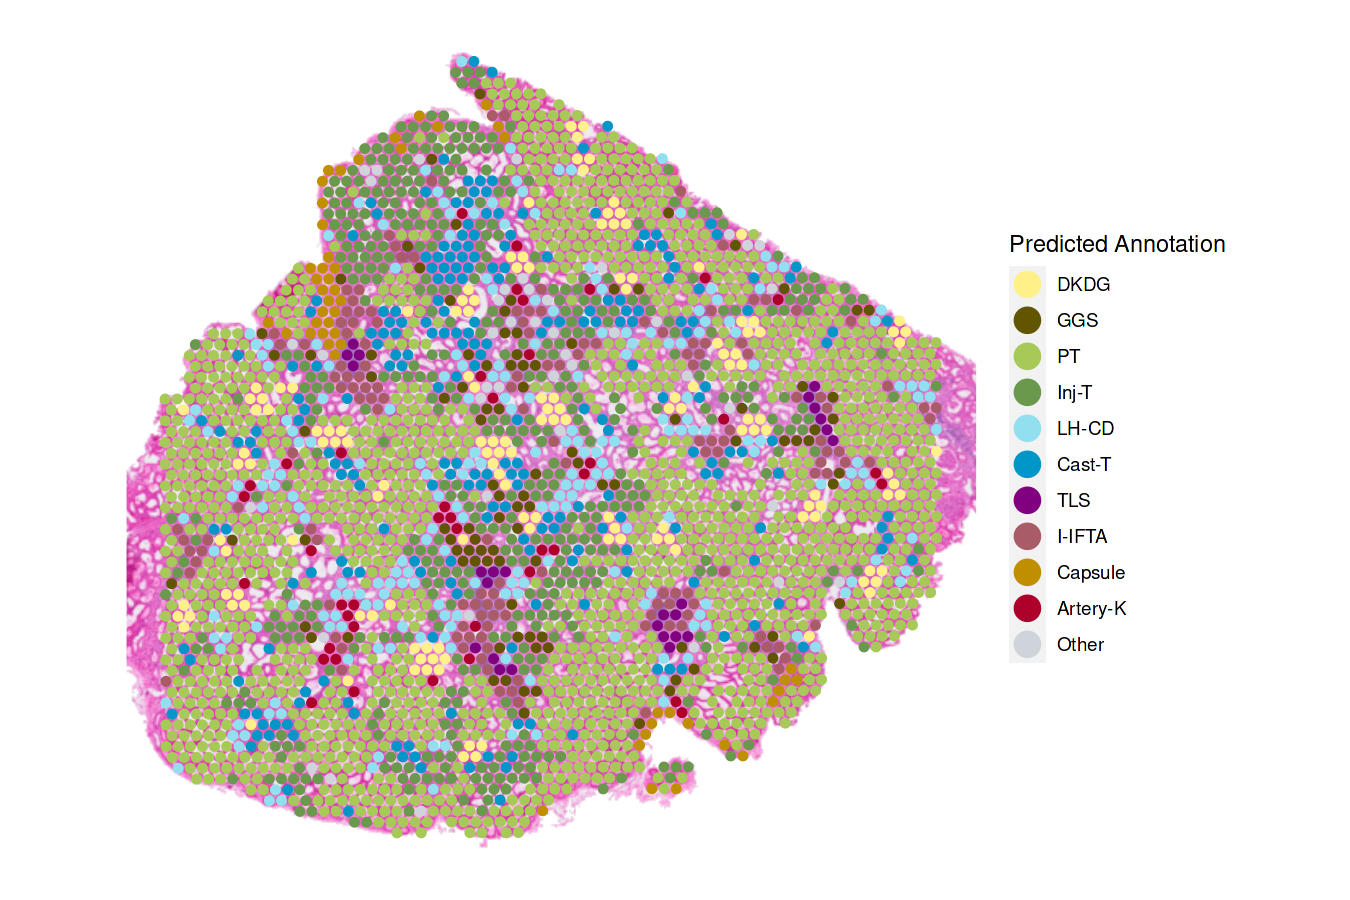

In [23]:
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 150)
Idents(dkd2) = dkd2$predicted.celltype
p <- SpatialDimPlot(dkd2, label = FALSE, cols = color_palette2, image.alpha = 1, stroke = 0, pt.size.factor = 1.2) + 
   guides(fill = guide_legend(override.aes = list(size=6), title="Predicted Annotation") ) 
p

ggsave(p, filename = file.path(plots_path_supp, "SpatialDimPlot_dkd2_query_dkd1.png"), width = 8, height = 5, units = "in", dpi = 300)
ggsave(p, filename = file.path(plots_path_supp, "SpatialDimPlot_dkd2_query_dkd1.pdf"), width = 8, height = 5, units = "in", dpi = 300)


#### Step 3.8. Dotplot to check marker genes for each cluster

In [24]:
Idents(dkd2) <- factor(dkd2$predicted.celltype , levels = rev(names(color_palette2)))

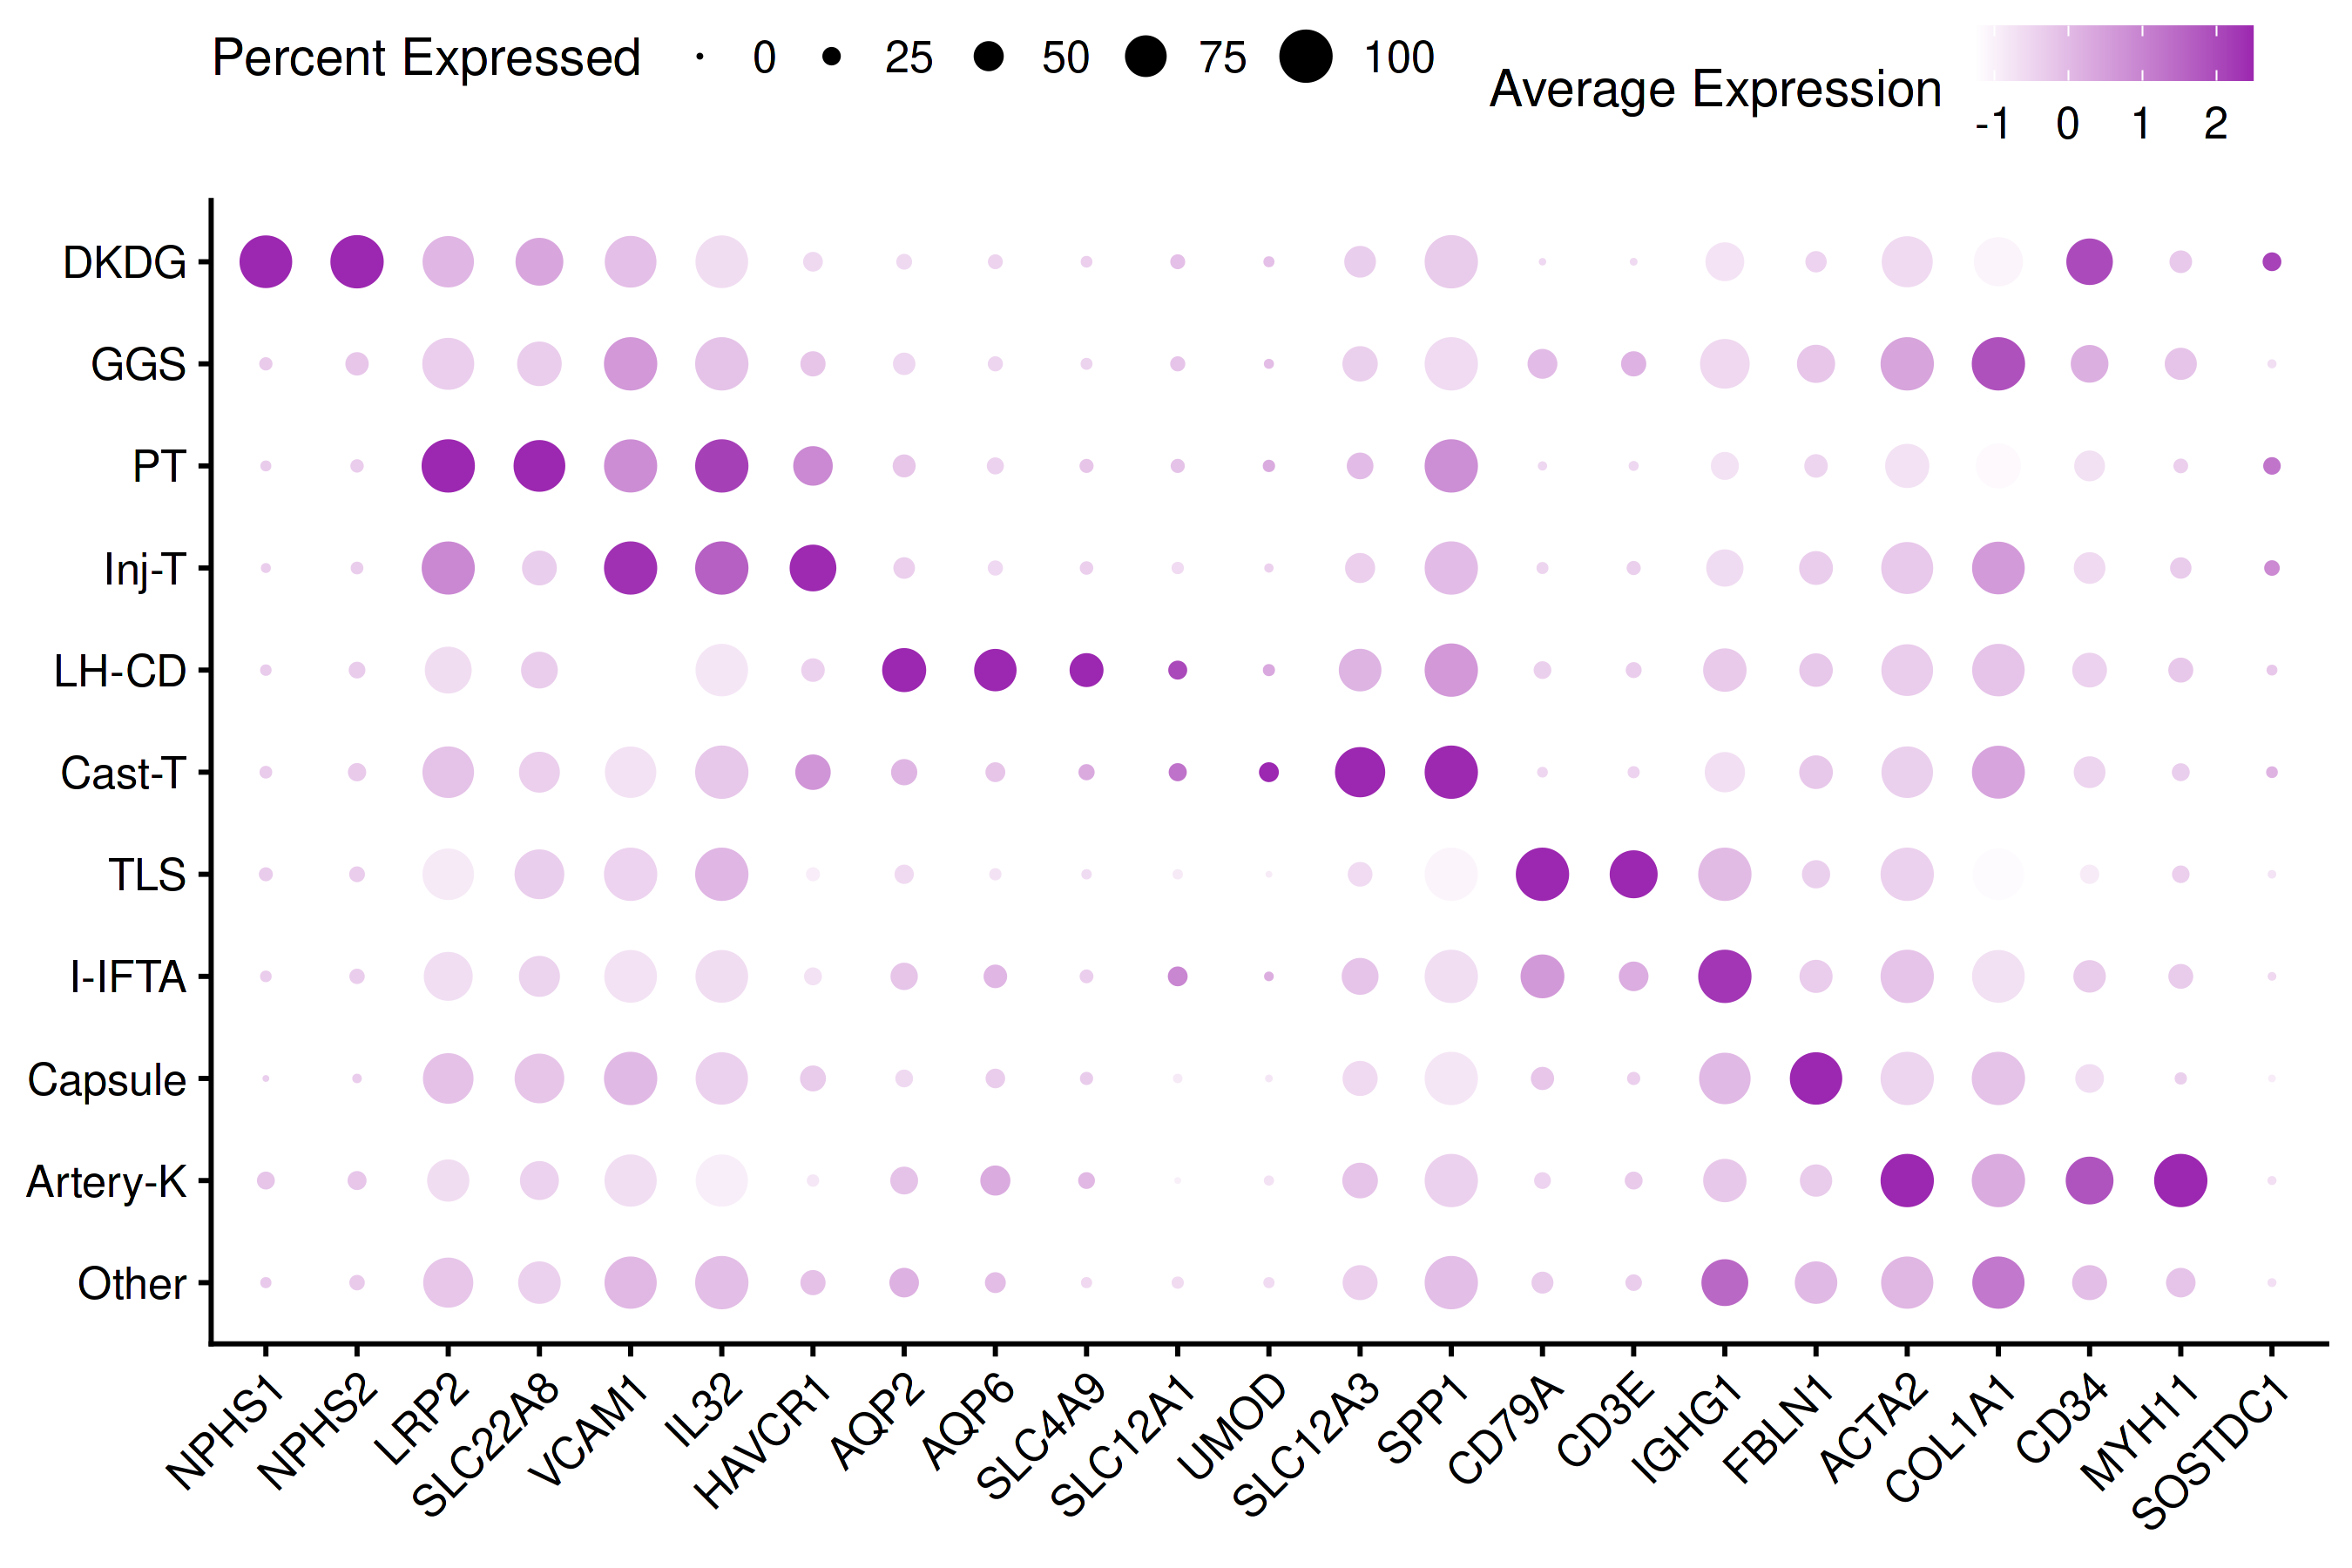

In [25]:
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 300)

feature_genes <- c("NPHS1", "NPHS2",
                   "LRP2", "SLC22A8",
                   "VCAM1", "IL32", "HAVCR1",
                   "AQP2", "AQP6", "SLC4A9", "SLC12A1", "UMOD", 
                   "SLC12A3", "SPP1", 
                   "CD79A", "CD3E",
                   "IGHG1",
                   "FBLN1", "ACTA2", "COL1A1", "CD34", "MYH11",
                   "SOSTDC1"
                  )
p = DotPlot(object = dkd2, features = feature_genes,
           cols = c("white", "#9C27B0")) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
     custom_theme + 
    theme(axis.title.x=element_blank(),
         axis.title.y=element_blank(),
         legend.position="top")
p

ggsave(p, filename = file.path(plots_path_main, "DotPlot_dkd2_query_dkd1.png"), width = 9, height = 6, units = "in", dpi = 300)
ggsave(p, filename = file.path(plots_path_main, "DotPlot_dkd2_query_dkd1.pdf"), width = 9, height = 6, units = "in", dpi = 300)


#### Step 3.9. Export meta data for CellScopes

In [26]:
meta.data = dkd2@meta.data
meta.data = meta.data[, -1]
meta.data$Barcode = rownames(meta.data)
# head(meta.data)
write.csv(meta.data, file = "../../meta/dkd2_meta.csv", row.names = F)

In [27]:
meta.data = meta.data[, c("Barcode", "predicted.celltype")]
meta.data$glom_sub = as.vector(meta.data$predicted.celltype)
meta.data$glom_sub[!meta.data$glom_sub %in% c("DKDG", "SGS", "GGS")] = "other"
# head(meta.data)
write.csv(meta.data, file = "../../meta/dkd2_meta_glom.csv", row.names = F)

In [28]:
meta.data = meta.data[, c("Barcode", "predicted.celltype")]
meta.data$glom_sub = as.vector(meta.data$predicted.celltype)
meta.data$glom_sub[!meta.data$glom_sub %in% c("DKDG")] = "other"
# head(meta.data)
write.csv(meta.data, file = "../../meta/dkd2_meta_glom_DKDG.csv", row.names = F)

In [29]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_1.1.3        ggplot2_3.4.4      sp_2.0-0           SeuratObject_4.1.0
[5] Seurat_4.1.1      

loaded via a namespace (and not attached):
  [1] Rtsne_0.16            colorspace_2.1-0      deldir_1.0-9         
  [4] ellipsis_0.3.2        ggridges_0.5.3       